In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-06-20 00:22:21,113 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-20 00:22:21,115 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-20 00:22:21,116 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-20 00:22:21,122 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-20 00:22:21,124 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-20 00:22:21,126 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
SITE_URL = 'https://www.python.org/'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'
DATASET_NAME = 'cnews'


### getting json

2021-06-20 00:22:21,416 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: cnews
2021-06-20 00:22:21,417 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-20 00:22:21,418 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-20 00:22:22,489 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-20 00:22:22,608 -INFO - <ipython-input-3-1703c48867d9>:<ipython-input-3-1703c48867d9>:10 - getting url: https://www.python.org/
2021-06-20 00:22:26,132 -INFO - common:common.py:75 - Window maximized
2021-06-20 00:22:26,133 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/cnews.png
2021-06-20 00:22:26,361 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-20 00:22:26,894 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/cnews.html
2021-06-20 00:22:26,904 -INFO - dataset_builder:dataset_builder.py:19

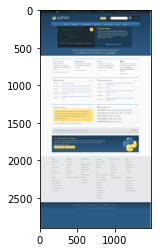

In [3]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=2900)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_df = builder.dataset
    login_json = builder.dataset_json

  

In [4]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [5]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '0417999980377463667703641992',
  'x': 157.0,
  'y': 1669.4375,
  'width': 1152.0,
  'height': 224.0,
  'predicted_label': 'link',
  'predicted_probability': 0.8024868965,
  'sort_key': 258048.0},
 {'element_id': '0684866467377463669498508374',
  'x': 733.0,
  'y': 1946.4375,
  'width': 196.0,
  'height': 574.46875,
  'predicted_label': 'link',
  'predicted_probability': 0.9345946908,
  'sort_key': 112595.875},
 {'element_id': '7653133142377463660636882569',
  'x': 157.0,
  'y': 1565.203125,
  'width': 1152.0,
  'height': 83.234375,
  'predicted_label': 'button',
  'predicted_probability': 0.6314831972,
  'sort_key': 95886.0},
 {'element_id': '7787390237377463662227538589',
  'x': 537.0,
  'y': 1946.4375,
  'width': 196.0,
  'height': 366.90625,
  'predicted_label': 'link',
  'predicted_probability': 0.9345946908,
  'sort_key': 71913.625},
 {'element_id': '4196091702377463669523174499',
  'x': 341.0,
  'y': 1946.4375,
  'width': 196.0,
  'height': 297.71875,
  'predicte

Wall time: 3.07 s


In [6]:
response

<Response [200]>

In [7]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:09.216152


In [8]:
predictions_df = pd.DataFrame(json.loads(response.text))


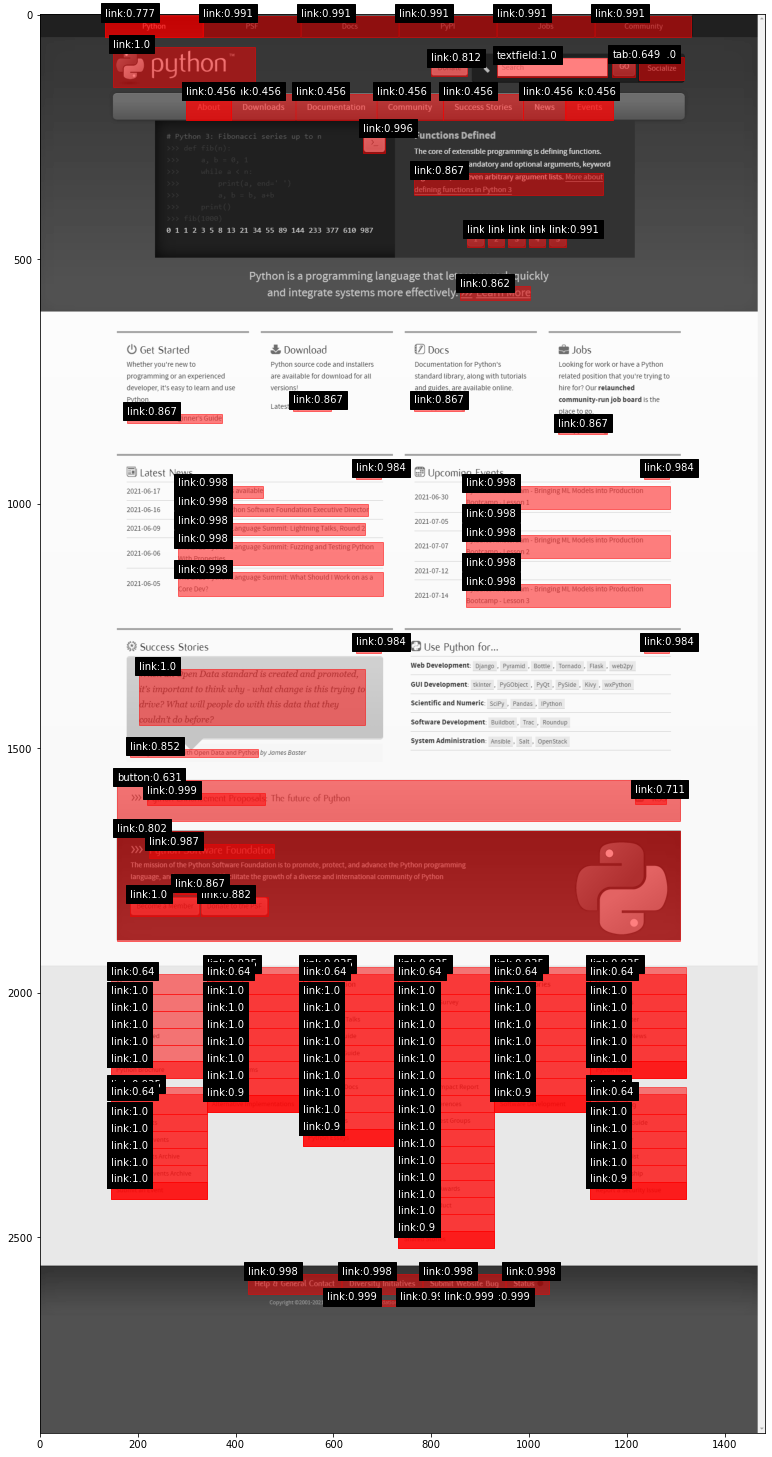

In [9]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, alpha=.5, color='red')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, r.predicted_label + ':' +str(round(r.predicted_probability, 3)), backgroundcolor='black', color='white')
    